#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub CORD-19 Swivel 埋め込みを探索する


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td>     <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを参照</a>   </td>
</table>

TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/1) の CORD-19 Swivel テキスト埋め込みモジュールは、COVID-19 に関連する自然言語テキストを分析する研究者をサポートするために構築されました。これらの埋め込みは、[CORD-19 データセット](https://api.semanticscholar.org/CorpusID:216056360)の論文のタイトル、著者、抄録、本文、および参照タイトルをトレーニングしています。

この Colab では、以下を取り上げます。

- 埋め込み空間内の意味的に類似した単語の分析
- CORD-19 埋め込みを使用した SciCite データセットによる分類器のトレーニング


## セットアップ


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity('ERROR')

import tensorflow_datasets as tfds
import tensorflow_hub as hub

try:
  from google.colab import data_table
  def display_df(df):
    return data_table.DataTable(df, include_index=False)
except ModuleNotFoundError:
  # If google-colab is not available, just display the raw DataFrame
  def display_df(df):
    return df

2024-01-11 19:14:39.268168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:14:39.268216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:14:39.269802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 埋め込みを分析する

まず、異なる単語間の相関行列を計算してプロットし、埋め込みを分析してみましょう。異なる単語の意味をうまく捉えられるように埋め込みが学習できていれば、意味的に似た単語の埋め込みベクトルは近くにあるはずです。COVID-19 関連の用語をいくつか見てみましょう。

2024-01-11 19:14:42.226805: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


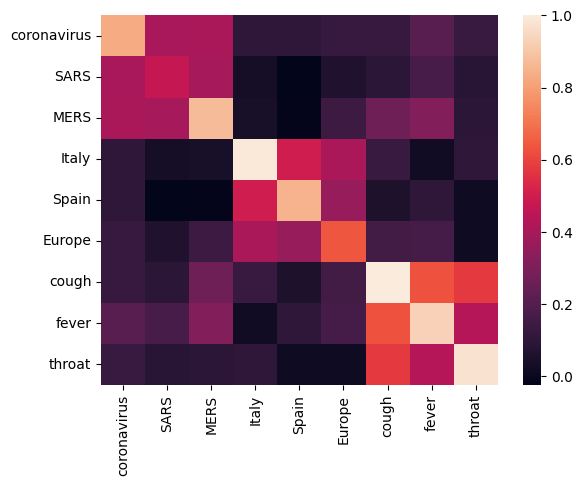

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)


with tf.Graph().as_default():
  # Load the module
  query_input = tf.placeholder(tf.string)
  module = hub.Module('https://tfhub.dev/tensorflow/cord-19/swivel-128d/1')
  embeddings = module(query_input)

  with tf.train.MonitoredTrainingSession() as sess:

    # Generate embeddings for some terms
    queries = [
        # Related viruses
        "coronavirus", "SARS", "MERS",
        # Regions
        "Italy", "Spain", "Europe",
        # Symptoms
        "cough", "fever", "throat"
    ]

    features = sess.run(embeddings, feed_dict={query_input: queries})
    plot_correlation(queries, features)

埋め込みが異なる用語の意味をうまく捉えていることが分かります。それぞれの単語は所属するクラスタの他の単語に類似していますが（「コロナウイルス」は「SARS」や「MERS」と高い関連性がある）、ほかのクラスタの単語とは異なります（「SARS」と「スペイン」の類似度はゼロに近い）。

では、これらの埋め込みを使用して特定のタスクを解決する方法を見てみましょう。

## SciCite: 引用の意図の分類

このセクションでは、テキスト分類など下流のタスクに埋め込みを使う方法を示します。学術論文の引用の意図の分類には、TensorFlow Dataset の <a href="https://www.tensorflow.org/datasets/catalog/scicite">SciCite データセット</a>を使用します。学術論文からの引用がある文章がある場合に、その引用の主な意図が背景情報、方法の使用、または結果の比較のうち、どれであるかを分類します。

In [4]:
#@title Set up the dataset from TFDS

class Dataset:
  """Build a dataset from a TFDS dataset."""
  def __init__(self, tfds_name, feature_name, label_name):
    self.dataset_builder = tfds.builder(tfds_name)
    self.dataset_builder.download_and_prepare()
    self.feature_name = feature_name
    self.label_name = label_name
  
  def get_data(self, for_eval):
    splits = THE_DATASET.dataset_builder.info.splits
    if tfds.Split.TEST in splits:
      split = tfds.Split.TEST if for_eval else tfds.Split.TRAIN
    else:
      SPLIT_PERCENT = 80
      split = "train[{}%:]".format(SPLIT_PERCENT) if for_eval else "train[:{}%]".format(SPLIT_PERCENT)
    return self.dataset_builder.as_dataset(split=split)

  def num_classes(self):
    return self.dataset_builder.info.features[self.label_name].num_classes

  def class_names(self):
    return self.dataset_builder.info.features[self.label_name].names

  def preprocess_fn(self, data):
    return data[self.feature_name], data[self.label_name]

  def example_fn(self, data):
    feature, label = self.preprocess_fn(data)
    return {'feature': feature, 'label': label}, label


def get_example_data(dataset, num_examples, **data_kw):
  """Show example data"""
  with tf.Session() as sess:
    batched_ds = dataset.get_data(**data_kw).take(num_examples).map(dataset.preprocess_fn).batch(num_examples)
    it = tf.data.make_one_shot_iterator(batched_ds).get_next()
    data = sess.run(it)
  return data


TFDS_NAME = 'scicite' #@param {type: "string"}
TEXT_FEATURE_NAME = 'string' #@param {type: "string"}
LABEL_NAME = 'label' #@param {type: "string"}
THE_DATASET = Dataset(TFDS_NAME, TEXT_FEATURE_NAME, LABEL_NAME)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES = 20  #@param {type:"integer"}
data = get_example_data(THE_DATASET, NUM_EXAMPLES, for_eval=False)
display_df(
    pd.DataFrame({
        TEXT_FEATURE_NAME: [ex.decode('utf8') for ex in data[0]],
        LABEL_NAME: [THE_DATASET.class_names()[x] for x in data[1]]
    }))

string       label
0   The finding that BMI is closely related to TBF...      result
1   The average magnitude of the NBR increases wit...  background
2   It has been reported that NF-κB activation can...      result
3   , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4   5B), but, interestingly, they shared conserved...  background
5   Some investigators have noted an association o...  background
6   In our previous study, it is documented that b...  background
7   These subjects have intact cognitive function ...  background
8   Another study reported improved knee function ...  background
9   C. Data Analysis Transcription Speech samples ...      method
10  o) was administered 14 days after the inductio...      method
11  showed that individuals who had previously exp...      result
12  However, a more stringent microarray experimen...  background
13  These results, of a fast short term depression...      result
14  The proportion of laboratory confirmed cases (...  background
15  Scientometric studies employing bibliometric a...      method
16  Our choice of studying CFI in higher detail is...  background
17  5 mg), GST-53BP2(715-1005) (1 mg), GST-GL(1-25...  background
18  DCS is preferable to External Storage (ES) at ...  background
19  RDo, where RD, RF and RDo represent relative d...      method

## 引用の意図分類器をトレーニングする

分類器のトレーニングには、<a href="https://www.tensorflow.org/datasets/catalog/scicite">SciCite データセット</a>に対して Estimator を使用します。input_fns を設定してデータセットをモデルに読み込みましょう。

In [6]:
def preprocessed_input_fn(for_eval):
  data = THE_DATASET.get_data(for_eval=for_eval)
  data = data.map(THE_DATASET.example_fn, num_parallel_calls=1)
  return data


def input_fn_train(params):
  data = preprocessed_input_fn(for_eval=False)
  data = data.repeat(None)
  data = data.shuffle(1024)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_eval(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.repeat(1)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_predict(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.batch(batch_size=params['batch_size'])
  return data

上に分類レイヤーを持ち、CORD-19 埋め込みを使用するモデルを構築してみましょう。

In [7]:
def model_fn(features, labels, mode, params):
  # Embed the text
  embed = hub.Module(params['module_name'], trainable=params['trainable_module'])
  embeddings = embed(features['feature'])

  # Add a linear layer on top
  logits = tf.layers.dense(
      embeddings, units=THE_DATASET.num_classes(), activation=None)
  predictions = tf.argmax(input=logits, axis=1)

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={
            'logits': logits,
            'predictions': predictions,
            'features': features['feature'],
            'labels': features['label']
        })
  
  # Set up a multi-class classification head
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
  loss = tf.reduce_mean(loss)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    precision = tf.metrics.precision(labels=labels, predictions=predictions)
    recall = tf.metrics.recall(labels=labels, predictions=predictions)

    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops={
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
        })


In [8]:
#@title Hyperparmeters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/1'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}
STEPS =   8000#@param {type: "integer"}
EVAL_EVERY = 200  #@param {type: "integer"}
BATCH_SIZE = 10  #@param {type: "integer"}
LEARNING_RATE = 0.01  #@param {type: "number"}

params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'module_name': EMBEDDING,
    'trainable_module': TRAINABLE_MODULE
}

## モデルをトレーニングして評価する

モデルをトレーニングして評価を行い、SciCite タスクでのパフォーマンスを見てみましょう。

In [9]:
estimator = tf.estimator.Estimator(functools.partial(model_fn, params=params))
metrics = []

for step in range(0, STEPS, EVAL_EVERY):
  estimator.train(input_fn=functools.partial(input_fn_train, params=params), steps=EVAL_EVERY)
  step_metrics = estimator.evaluate(input_fn=functools.partial(input_fn_eval, params=params))
  print('Global step {}: loss {:.3f}, accuracy {:.3f}'.format(step, step_metrics['loss'], step_metrics['accuracy']))
  metrics.append(step_metrics)

2024-01-11 19:14:46.602646: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_104176/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


2024-01-11 19:14:48.222056: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 0: loss 0.842, accuracy 0.636


2024-01-11 19:14:49.978652: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:14:51.615497: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 200: loss 0.740, accuracy 0.703


2024-01-11 19:14:53.260719: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:14:54.679780: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 400: loss 0.684, accuracy 0.737


2024-01-11 19:14:56.356281: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:14:57.807068: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 600: loss 0.649, accuracy 0.751


2024-01-11 19:14:59.467871: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:00.894589: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 800: loss 0.637, accuracy 0.749


2024-01-11 19:15:02.610492: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:04.081191: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1000: loss 0.629, accuracy 0.754


2024-01-11 19:15:05.722098: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:07.136146: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1200: loss 0.604, accuracy 0.770


2024-01-11 19:15:08.777994: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:10.244259: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1400: loss 0.598, accuracy 0.766


2024-01-11 19:15:11.911174: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:13.285140: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1600: loss 0.587, accuracy 0.775


2024-01-11 19:15:14.942509: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:16.353150: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 1800: loss 0.578, accuracy 0.776


2024-01-11 19:15:18.047069: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:19.417233: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2000: loss 0.582, accuracy 0.771


2024-01-11 19:15:21.073059: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:22.539460: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2200: loss 0.577, accuracy 0.776


2024-01-11 19:15:24.225553: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:25.624548: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2400: loss 0.572, accuracy 0.777


2024-01-11 19:15:27.265684: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:28.690927: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2600: loss 0.568, accuracy 0.779


2024-01-11 19:15:30.326410: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:31.769095: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 2800: loss 0.568, accuracy 0.778


2024-01-11 19:15:33.414151: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:34.849879: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3000: loss 0.559, accuracy 0.783


2024-01-11 19:15:36.508477: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:37.994444: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3200: loss 0.561, accuracy 0.786


2024-01-11 19:15:39.638953: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:41.057612: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3400: loss 0.566, accuracy 0.774


2024-01-11 19:15:43.015137: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:44.365486: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3600: loss 0.553, accuracy 0.783


2024-01-11 19:15:46.039061: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:47.514670: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 3800: loss 0.563, accuracy 0.772


2024-01-11 19:15:49.159915: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:50.506473: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4000: loss 0.560, accuracy 0.779


2024-01-11 19:15:52.129647: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:53.559881: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4200: loss 0.554, accuracy 0.782


2024-01-11 19:15:55.225119: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:56.639571: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4400: loss 0.552, accuracy 0.778


2024-01-11 19:15:58.273462: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:15:59.725267: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4600: loss 0.553, accuracy 0.781


2024-01-11 19:16:01.378686: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:02.802899: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 4800: loss 0.551, accuracy 0.782


2024-01-11 19:16:04.437966: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:05.884323: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5000: loss 0.549, accuracy 0.783


2024-01-11 19:16:07.527458: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:08.986769: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5200: loss 0.550, accuracy 0.777


2024-01-11 19:16:10.649124: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:12.121480: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5400: loss 0.554, accuracy 0.773


2024-01-11 19:16:13.823252: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:15.215645: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5600: loss 0.543, accuracy 0.788


2024-01-11 19:16:16.862731: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:18.317355: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 5800: loss 0.545, accuracy 0.778


2024-01-11 19:16:19.961560: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:21.406026: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6000: loss 0.541, accuracy 0.786


2024-01-11 19:16:23.045624: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:24.537088: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6200: loss 0.541, accuracy 0.788


2024-01-11 19:16:26.181818: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:27.724668: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6400: loss 0.538, accuracy 0.787


2024-01-11 19:16:29.364966: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:30.723931: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6600: loss 0.542, accuracy 0.787


2024-01-11 19:16:32.384707: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:34.110425: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 6800: loss 0.542, accuracy 0.794


2024-01-11 19:16:35.753712: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:37.173630: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7000: loss 0.542, accuracy 0.789


2024-01-11 19:16:38.802880: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:40.201037: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7200: loss 0.537, accuracy 0.792


2024-01-11 19:16:41.840580: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:43.260351: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7400: loss 0.535, accuracy 0.790


2024-01-11 19:16:44.948129: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:46.328297: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7600: loss 0.550, accuracy 0.781


2024-01-11 19:16:48.010033: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


2024-01-11 19:16:49.480537: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.


Global step 7800: loss 0.541, accuracy 0.787


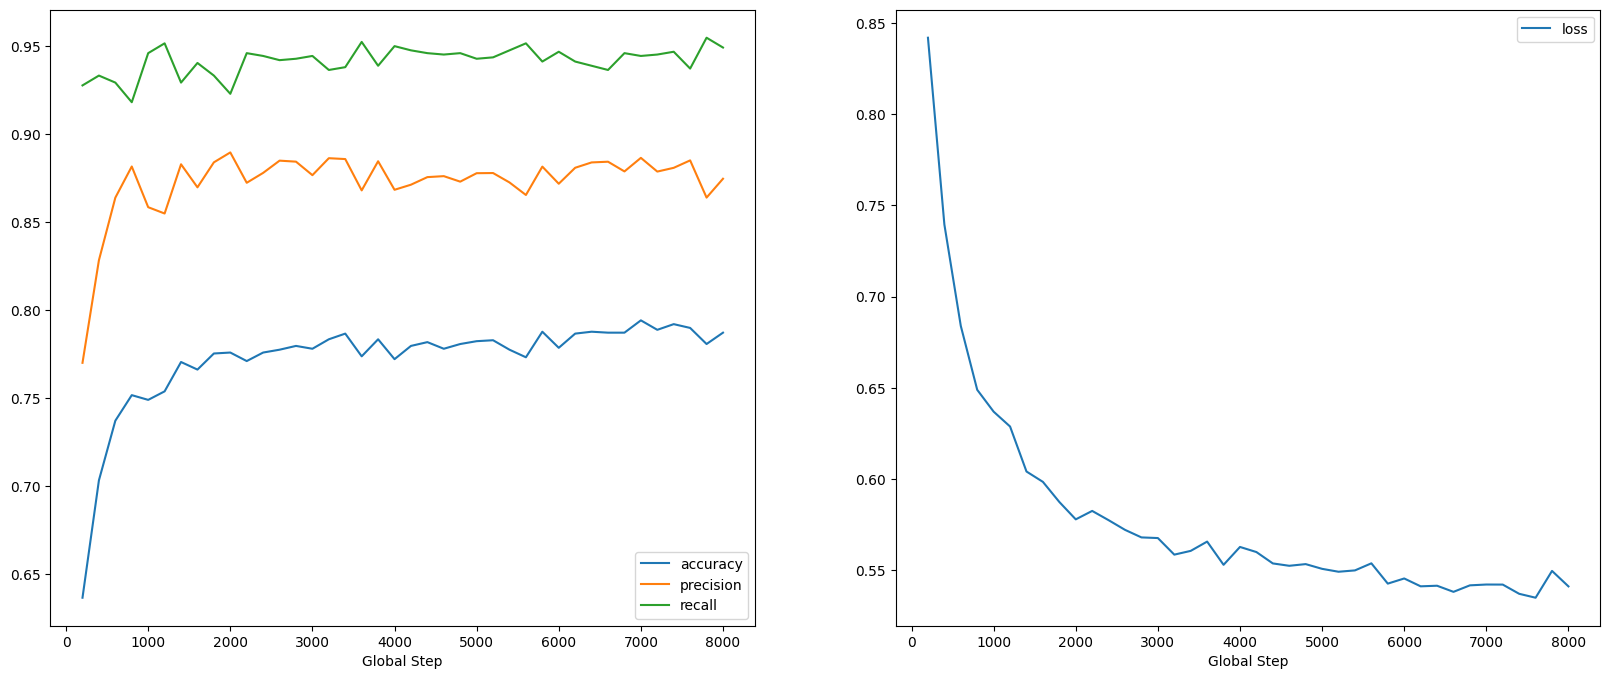

In [10]:
global_steps = [x['global_step'] for x in metrics]
fig, axes = plt.subplots(ncols=2, figsize=(20,8))

for axes_index, metric_names in enumerate([['accuracy', 'precision', 'recall'],
                                            ['loss']]):
  for metric_name in metric_names:
    axes[axes_index].plot(global_steps, [x[metric_name] for x in metrics], label=metric_name)
  axes[axes_index].legend()
  axes[axes_index].set_xlabel("Global Step")

損失はすぐに減少しますが、特に精度は急速に上がることが分かります。予測と真のラベルがどのように関係しているかを確認するために、いくつかの例をプロットしてみましょう。

In [11]:
predictions = estimator.predict(functools.partial(input_fn_predict, params))

In [12]:
first_10_predictions = list(itertools.islice(predictions, 10))

display_df(
  pd.DataFrame({
      TEXT_FEATURE_NAME: [pred['features'].decode('utf8') for pred in first_10_predictions],
      LABEL_NAME: [THE_DATASET.class_names()[pred['labels']] for pred in first_10_predictions],
      'prediction': [THE_DATASET.class_names()[pred['predictions']] for pred in first_10_predictions]
  }))

2024-01-11 19:16:51.528015: W tensorflow/core/common_runtime/graph_constructor.cc:1583] Importing a graph with a lower producer version 27 into an existing graph with producer version 1645. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_104176/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


string       label  prediction
0  The diffraction grating, LED, and split detect...  background      method
1  Our ideas are based on a previous paper [4] de...  background      method
2  Our finding is consistent with the literature ...      result      result
3  Test scores from each of the cognitive domains...      method      method
4  The optimization algorithm was set to maximize...      method      method
5  To quantify the extent of substitution saturat...      method      method
6  Examples of gesture control are based on the e...      method      method
7  The identification of these features has been ...      method      result
8  Postulated mechanisms for observed effects of ...  background  background
9  The right inferior phrenic artery is the most ...  background  background

このランダムサンプルでは、ほとんどの場合、モデルが正しいラベルを予測しており、科学的な文をうまく埋め込むことができていることが分かります。

# 次のステップ

TF-Hub の CORD-19 Swivel 埋め込みについて少し説明しました。COVID-19 関連の学術的なテキストから科学的洞察の取得に貢献できる、CORD-19 Kaggle コンペへの参加をお勧めします。

- [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) に参加しましょう。
- 詳細については [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360) をご覧ください。
- TF-Hub 埋め込みに関する詳細のドキュメントは https://tfhub.dev/tensorflow/cord-19/swivel-128d/1 をご覧ください。
- [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/1/tensorboard/full_projector_config.json) を利用して CORD-19 埋め込み空間を見てみましょう。